In [21]:
from typing import Annotated

from typing_extensions import TypedDict

# Langgraph imports
# Mainly defines how to build the graph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, BaseMessage
from langchain.globals import set_verbose
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


# LLM imports
from langchain_ollama import ChatOllama
from langchain_ollama.llms import OllamaLLM

from open_eval.prompt_templates import (
    eval_steps_template,
    extract_facts, 
    extract_assertions, 
    generic_criteria_template, 
    rubric_template
)



In [34]:
llm = OllamaLLM(model="llama3:8b", verbose=True)

# Define the state graph
class State(TypedDict):
    """
    The graph state that flows between nodes.
    * `messages` – a list of LangChain messages (the chat history).
    * `criteria` / `criteria_desc` – set once by `run_evaluation`.
    * `evaluation_steps` – generated by `get_eval_steps`.
    * `result` – final LLM output from `evaluate_criteria`.
    """
    messages: Annotated[list[BaseMessage], "add_messages"]  # add_messages tells Graph to append
    criteria: str
    criteria_desc: str
    evaluation_steps: list[str]
    result: str


def run_evaluation(state: State) -> str:
    criteria = "Helpfulness"
    criteria_desc = "The response should be helpful and provide useful information."
    print (f"Criteria: {criteria}\n"
           f"Criteria Desc: {criteria_desc}")
    return {
        "criteria": criteria,
        "criteria_desc": criteria_desc
    }

def get_eval_steps(state: State) -> str:
    # Extract the evaluation steps from the state
    prompt = ChatPromptTemplate.from_messages(
        [
            MessagesPlaceholder(variable_name="messages"),
            eval_steps_template,
        ]
    )
    # print(prompt.format_messages(**state))
    print (state)
    eval_steps = llm.invoke(prompt.format_messages(**state))
    start_idx = eval_steps.find("{")          # first occurrence of '{'
    end_idx   = eval_steps.rfind("}")         # last occurrence of '}'
    return {
        "criteria": state.get('criteria'),
        "criteria_desc": state.get('criteria_desc'),
        "evaluation_steps": eval_steps[start_idx + 1:end_idx]
    }

def evaluate_criteria(state: State) -> bool:
    print(f"Evaluating criteria: {state}")
    # Check if the messages in the state meet certain criteria
    input_criteria = state.get('criteria')
    input_test_case = state.get('test_case')
    # run the evaluation
    eval = llm.invoke()
    return eval




In [ ]:
def build_graph():
    memory = InMemorySaver()

    graph_builder = StateGraph(State, verbose=True)


    # Add the nodes to the graph
    graph_builder.add_node(
        "run_evaluation",
        run_evaluation,
        # inputs=["messages"],
        # outputs=["criteria", "criteria_desc"],
    )

    graph_builder.add_node(
        "get_eval_steps",
        get_eval_steps,
        # inputs=["criteria", "criteria_desc"],
        # outputs=["eval_steps"],
    )

    graph_builder.add_node(
        "evaluate_criteria",
        evaluate_criteria,
        # inputs=["criteria", "test_case"],
        # outputs=["result"],
    )
    graph_builder.add_edge(START, "run_evaluation")
    graph_builder.add_edge("run_evaluation", "get_eval_steps")
    graph_builder.add_edge("get_eval_steps", "evaluate_criteria")
    graph_builder.add_edge("evaluate_criteria", END)
    # Compile the graph
    graph = graph_builder.compile()

    return graph


In [36]:
graph = build_graph()

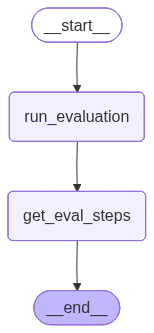

In [37]:
from IPython.display import Image, display
Image(graph.get_graph().draw_mermaid_png())

In [38]:
# Example: start with a user message we want to evaluate
from langchain_core.messages import HumanMessage

initial_state = {
    "messages": [HumanMessage(content="How do I reset my router?")],
    # The rest of the keys will be filled by the graph
}

In [39]:
res = graph.invoke(initial_state)

Criteria: Helpfulness
Criteria Desc: The response should be helpful and provide useful information.
{'messages': [HumanMessage(content='How do I reset my router?', additional_kwargs={}, response_metadata={})], 'criteria': 'Helpfulness', 'criteria_desc': 'The response should be helpful and provide useful information.'}


In [41]:
res['evaluation_steps']

'\n    "evaluation_steps": [\n        "Determine if the RESPONSE provides specific and relevant information to the question or topic.",\n        "Check if the RESPONSE offers actionable advice or suggestions that can be applied to real-life situations.",\n        "Evaluate if the RESPONSE includes relevant examples, analogies, or illustrations to help explain complex concepts.",\n        "Assess if the RESPONSE addresses potential concerns, questions, or issues related to the topic.",\n        "Determine a score between 1-5 where 1 means the RESPONSE is not helpful and 5 means the RESPONSE is extremely helpful and provides useful information."\n    ]\n'